In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geemap
import ee
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()
        

#### Import ImageCollection

In [2]:
# image collection
imageCollection = ee.ImageCollection("MODIS/061/MCD12Q1").filter(ee.Filter.date('2017-01-01', '2018-01-01'))

# Get a list of all the image IDs (I'll use it to fetch images directly using ee.Image())
image_ids = imageCollection.aggregate_array("system:id").getInfo()

#get the first image and gather bandnames
bandNames=ee.Image(image_ids[0]).bandNames().getInfo()

# Boundary of region of interest
roi = ee.Geometry.Rectangle([27, -30, 28, -27]) #xmin, ymin, xmax, ymax
point_roi=ee.Geometry.Point(1, 36.5)

# Function to mask all values outside the geometry
def maskOutside(image, geometry):
    mask = ee.Image.constant(1).clip(geometry).mask() # add .not() to mask inside
    return image.updateMask(mask)

#### Get bandNames

In [3]:
#get the first image and gather bandnames of interest
subset_bands=[band for band in bandNames if band.startswith(('LC_Type1'))]
subset_bands
#filter imagecollection to select bands of interest
select_bands=imageCollection.select(subset_bands)

subset_bands

['LC_Type1']

### Resample to monthly averages (Optional)

In [ ]:
#resample image collection to monthly means
def aggregate_monthly(year, month):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    # Filter the image collection to the specific month
    monthly_images = select_bands.filterDate(start_date, end_date)
    
    # Apply a mean reducer
    monthly_mean = monthly_images.mean().set('system:time_start', start_date.millis())
    
    return monthly_mean

# Define the date range for aggregation
start_year = 2003
end_year = 2020

# Create a list of months for each year
months = ee.List.sequence(1, 12)
years = ee.List.sequence(start_year, end_year)

# Map over the years and months to generate the monthly aggregated images
monthly_images = years.map(lambda y: months.map(lambda m: aggregate_monthly(ee.Number(y), ee.Number(m))))

# Flatten the list of lists to a single image collection
monthly_image_collection = ee.ImageCollection(ee.List(monthly_images).flatten())

In [ ]:
aggregate_monthly(2003, 1)

## Extracting timeseries data from a select region

> GEE plotting UI is not available for python. So a work around is needed  
> Extract data as pandas df for plotting  
> Get images in collection and average the data in the region of interest 
>
> Ref: https://worldbank.github.io/OpenNightLights/tutorials/mod4_1_time_series_charts.html

In [7]:
bands = subset_bands #['SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', 'SoilMoi100_200cm_tavg']

# Boundary of region of interest
roi = ee.Geometry.Rectangle([33.8, -0.5, 39.8, 5.0]) #xmin, ymin, xmax, ymax
"""change Sscale according to resolution of dataset"""
scale = 5600  

def roi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=scale).get(band)
    return img.set('date', img.date().format()).set(band,mean) #set band name as mean

df_list = []
for band in bands:

    #clip the image collection to the region of interest
    """pass the image collection of interest here"""
    imc_region = select_bands.map(lambda img: maskOutside(img, roi))

    #map the function over the image collection
    roi_means = imc_region.map(roi_mean)

    #reduce the collection to a list
    poi_means_list = roi_means.reduceColumns(ee.Reducer.toList(2), ['date', band]).values().get(0)

    #convert nested lists to pandas dataframe to retrieve data
    df = pd.DataFrame(poi_means_list.getInfo(), columns=['date', band])
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    df_list.append(df)

#concatenate the dataframes
df_bands= pd.concat(df_list, axis=1)

In [15]:
df_bands.isnull().sum()

LE    0
dtype: int64

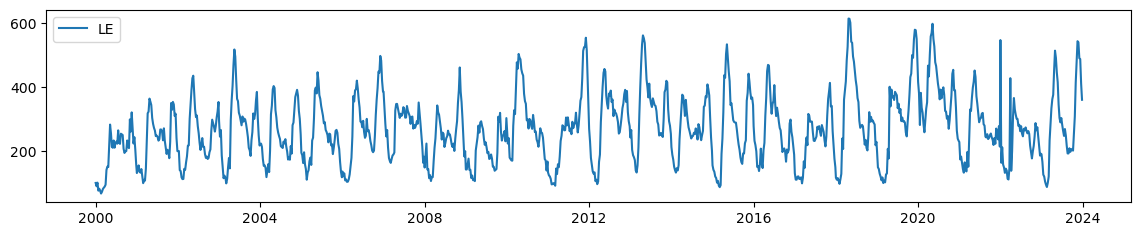

In [16]:
fig,ax=plt.subplots(figsize=(14,2.5))
plt.plot(df_bands, label=df_bands.columns);
#plt.ylim(0.1, 0.5);
plt.legend(bands, loc='upper left', ncol=2);

#### Bulk download original ImageCollection Tiffs with native projection

> Specify bands to download if multiple

In [17]:
# Download each image with both layers: sm_surface and sm_rootzone
"""name of folder in Google Drive"""
download_folder = "MODIS_LH_Flux" 
bands = subset_bands

for image_id in image_ids:
    image = ee.Image(image_id).select(bands).clip(roi)

    # Replace all values outside region with -9999
    image = maskOutside(image, roi).unmask(-9999)

    # Get the original CRS and geotransform of the image
    proj = image.projection().getInfo()

    # Export each band separately with a unique filename
    for band in bands:
        # Create a filename for the downloaded image
        filename = f"{image_id.split('/')[0]}_{image_id.split('/')[-1]}_{band}"

        # Export the image with the original CRS and geotransform
        task = ee.batch.Export.image.toDrive(
            image=image.select(band),
            region=roi,
            description=filename,
            folder=download_folder,
            crs=proj["crs"],
            crsTransform=proj["transform"],
            maxPixels=1e13,
            fileFormat="GeoTIFF"
        )
        task.start()
        print(f"Exporting {filename}...", end="\r")

##### Get CRS and scale of images

In [4]:
#extract projection information
image=ee.Image(image_ids[0])
projection=image.projection().getInfo()

target_scale=projection['transform'][0]
target_scale

463.3127165279165

In [5]:
image_ids[0]

'MODIS/061/MCD12Q1/2017_01_01'

In [6]:
projection

{'type': 'Projection',
 'crs': 'SR-ORG:6974',
 'transform': [463.3127165279165,
  0,
  -20015109.354,
  0,
  -463.3127165279167,
  10007554.677003]}

#### Bulk download original imageCollection with specific projection

> The target scale property is derived from the geotransform of the images i.e. by running image.projection().getInfo()
> The resolution also has to be changed

In [ ]:
bands = subset_bands
download_folder = 'SMAP_L4_2016_'  # name of folder in Google Drive

# Define the EPSG:4326 projection with appropriate scale
target_projection = 'EPSG:4326'
target_scale = #463.3127165279165 to latlon
target_scale = 

for image_id in image_ids:
    image = ee.Image(image_id).select(bands).clip(roi)

    # Replace all values outside the region with -9999
    image = maskOutside(image, roi).unmask(-9999)

    # Export each band separately with a unique filename
    for band in bands:
        # Create a filename for the downloaded image
        filename = f"{image_id.split('/')[0]}_{image_id.split('/')[-1]}_{band}"

        # Export the image with the EPSG:4326 projection and specified scale
        task = ee.batch.Export.image.toDrive(
            image=image.select(band).reproject(crs=target_projection, scale=target_scale),
            region=roi,
            description=filename,
            folder=download_folder,
            crs=target_projection,
            scale=target_scale,
            maxPixels=1e13,
            fileFormat="GeoTIFF"
        )
        task.start()
        print(f"Exporting {filename}...", end="\r")

### Bulk Download Resampled image collection

In [ ]:
image_list = monthly_image_collection.toList(monthly_image_collection.size())

bands = bands  # Example band names
download_folder = "plm_v2_GPP_ET"  # Name of folder in Google Drive
scale = target_scale  # Change according to resolution of dataset

# Loop through each image in the list
for i in range(image_list.size().getInfo()):
    image = ee.Image(image_list.get(i))
    image = image.select(bands).clip(roi)

    # Replace all values outside region with -9999
    image = maskOutside(image, roi).unmask(-9999)

    # Get the timestamp and format it
    timestamp = ee.Date(image.get('system:time_start')).format('yyyy-MM-dd').getInfo()

    # Get the original CRS and geotransform of the image
    proj = image.projection().getInfo()

    # Export each band separately with a unique filename
    for band in bands:
        # Create a filename for the downloaded image including timestamp
        filename = f"{timestamp}_{band}"

        # Export the image with the original CRS and geotransform
        task = ee.batch.Export.image.toDrive(
            image=image.select(band),
            region=roi,
            scale=scale,
            description=filename,
            folder=download_folder,
            crs=proj["crs"],
            crsTransform=proj["transform"],
            maxPixels=1e13,
            fileFormat="GeoTIFF"
        )
        task.start()

        print(f"Exporting {filename}...", end="\r")

print("\nAll tasks started.")

### Cancelling tasks

In [18]:
# Get a list of all tasks
tasks = ee.batch.Task.list()

# Cancel all tasks
for task in tasks:
    if task.state in ['RUNNING', 'READY']:
        print(f"Cancelling task {task.id}", end="\r")
        task.cancel()
print("All tasks cancelled.")

All tasks cancelled.LP5DXMSSO7XP3ROOYAMU
